In [25]:
# 7_plots_splicing.ipynb
# Ashley Mae Conard
# Last Mod. 9/12/2019
# Purpose: Plot and save transcript abundances using PSI and DTU measures.
# Note: Timepoint 0-2 is used here as an example.

# TO USE: Complete up to 6 steps based on need. Run through entire analysis for each timepoint separately.

import pandas as pd
pd.set_option('display.max_colwidth',-1)
import glob
import collections as c
import os
import sys
from scipy import stats
import seaborn as sns
from io import StringIO
import matplotlib.pyplot as plt; plt.rcdefaults()
%matplotlib inline
from matplotlib_venn import venn2
import numpy as np

/home/aconard/anaconda/envs/time2splice/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  # Remove the CWD from sys.path while we load stuff.


# 1. USER INPUT
#### (Please edit with your own data, then run.)

In [16]:
# Input directories needed
INPUTDIR = "/Users/pranavmahableshwarkar/BrownUniversity/LarschanLab/JupyterInputs/suppa_clamprnai"
GENES_GTF = "/Users/pranavmahableshwarkar/BrownUniversity/LarschanLab/JupyterInputs/genes.gtf"

# Category information
CAT1 = "S2 Male GFP vs S2 Male CLAMPRNAi"
CAT2 = "KC Female GFP vs KC Female CLAMPRNAi"
CAT3 = "KC Female CLAMPRNAi vs S2 Male CLAMPRNAi"

# Time information
TIME = "Adult"

# PSI information
INPUTFILE_PSI_CTRL = INPUTDIR+"/merged_gfp_fm/S2_GFP_vs_KC_GFP_diffSplice.dpsi" # control
INPUTFILE_PSI_CAT1 = INPUTDIR+"/merged_clampvgfp_m/S2_CLAMP_vs_S2_GFP_diffSplice.dpsi" # category 1 
INPUTFILE_PSI_CAT2 = INPUTDIR+"/merged_clampvgfp_f/KC_CLAMP_vs_KC_GFP_diffSplice.dpsi" # category 2
INPUTFILE_PSI_CAT3 = INPUTDIR+"/merged_clamp_fm/S2_CLAMP_vs_KC_CLAMP_diffSplice.dpsi" # category 3
input_files = [INPUTFILE_PSI_CTRL, INPUTFILE_PSI_CAT1, INPUTFILE_PSI_CAT2, INPUTFILE_PSI_CAT3]

# CONTROL ONLY PSI and pval
PSI = "S2_GFP_iso_events-KC_GFP_iso_events_dPSI"
pval = "S2_GFP_iso_events-KC_GFP_iso_events_p-val"

# Control vs Mutant (You must edit all column headings to be the same for CAT1 and CAT2)

# DTU information
INPUTFILE_DTU_CTRL = INPUTDIR+"/control_m_f/f_control_vs_m_control_diffSplice_iso_dtu.dpsi" # control
INPUTFILE_DTU_CAT1 = INPUTDIR+"/m_control_delgi/m_delgi_vs_m_control_diffSplice_iso_dtu.dpsi" # category 1 
INPUTFILE_DTU_CAT2 = INPUTDIR+"/f_control_delgi/f_delgi_vs_f_control_diffSplice_iso_dtu.dpsi" # category 2
INPUTFILE_DTU_CAT3 = INPUTDIR+"/delgi_m_f/f_delgi_vs_m_delgi_diffSplice_iso_dtu.dpsi" # category 2
pvaldtu = "DelGI_iso_tpm-control_iso_tpm_p-val" # p-value column name 
DTU = "DelGI_iso_tpm-control_iso_tpm_dPSI" # DTU column name 

TITLE1 = "KC Female GFP vs S2 Male GFP"
TITLE2 = "S2 Male GFP vs S2 Male CLAMPRNAi"
TITLE3 = "KC Female GFP vs KC Female CLAMPRNAi"
TITLE4 = "KC Female CLAMPRNAi vs S2 Male CLAMPRNAi"
titles = [TITLE1, TITLE2, TITLE3, TITLE4]

OUTPUT_NAME1 = "Adult_GFP_KCS2"
OUTPUT_NAME2 = "Adult_S2_GFPCLAMP"
OUTPUT_NAME3 = "Adult_KC_GFPCLAMP"
OUTPUT_NAME4 = "Adult_CLAMP_KCS2"
names = [OUTPUT_NAME1, OUTPUT_NAME2, OUTPUT_NAME3, OUTPUT_NAME4]


# Output directories
OUTDIR = "/Users/pranavmahableshwarkar/BrownUniversity/LarschanLab/JupyterInputs/7_plots_splicing_clamprnai"

# 2. Various Functions
#### (see comments for details)

In [22]:
# Calc. intersection
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

# Parse the genes.gtf index
def parse_index(row):
    string = row.name
    list_of_words = string.split(";") 
    return(list_of_words[0])

# Create nan dataframe
nans = lambda df: df[df.isnull().any(axis=1)]

# Formatting genes.gtf file
def create_cols(row):
    string = row['allInfo']
    list_of_words = string.split()
    next_word = list_of_words[list_of_words.index(search_word) + 1]  
    return(next_word)

# Add the exon id from genes.gtf
def add_exon_id(row):
    string = row['allInfo'] 
    if "exon_id" in string:
        return(string.split( )[1].strip('"').strip('"').strip(";").strip('"'))
    else:
        return("NA")

# Add the exon number from genes.gtf
def add_exon_number(row):
    string = row['allInfo'] 
    if "exon_number" and not"exon_id" in string:
        return(string.split( )[1].strip('"').strip('"').strip(";").strip('"'))
    elif "exon_number" in string:
        return(string.split( )[3].strip('"').strip('"').strip(";").strip('"'))
    else:
        return("NA")
    
# Define split for dPSI
pos_neg = ["b","p","n"]

# 3. Volcano Plots

## PSI

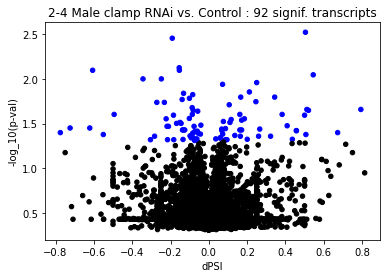

In [13]:
index = 0;
for dpsi_input_file in input_files:
    # Output names for volcano plots of controls
    OUTPUT_NAME = names[index]
    TITLE_PLOT = titles[index]
    
    dfpsi = pd.read_csv(dpsi_input_file, sep="\t")
    dfpsi["nlog10_pval"] = -np.log10(dfpsi[dfpsi.columns[1]])

    cols = np.where(dfpsi["nlog10_pval"]>=1.25963731,'b','k') # log_10 p-val 0.05 is ~1.3
    dfpsi.plot.scatter(c = cols, x=dfpsi.columns[0], y='nlog10_pval')

    plt.title('%s : %s signif. transcripts'%(TITLE_PLOT, cols.tolist().count('b')))
    plt.xlabel("dPSI")
    plt.ylabel('-log_10(p-val)')

    # Show graphic
    plt.savefig(OUTDIR+"/"+OUTPUT_NAME+"_volcano_PSI.pdf")
    index += 1
    

## DTU

/Users/ashleymaeconard/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


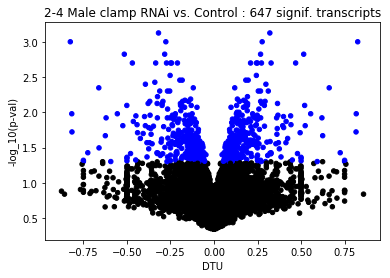

In [65]:
# Plot volcano given DTU
controls_input_0_2_cf_cm_DTU = INPUTFILE_DTU_CTRL
df_0_2_cf_cm_DTU = pd.read_csv(controls_input_0_2_cf_cm_DTU, sep="\t")

dfdtu = pd.read_csv(INPUTFILE_DTU, sep="\t")
dfdtu["nlog10_pval"] = -np.log10(dfdtu[dfdtu.columns[1]])

cols = np.where(dfdtu["nlog10_pval"]>=1.301029995664,'b','k') # p-val 0.05
dfdtu.plot.scatter(c = cols, x='clampRNAi_iso_tpm-control_iso_tpm_dPSI',
                   y='nlog10_pval')

plt.title('%s : %s signif. transcripts'%(TITLE_PLOT, cols.tolist().count('b')))
plt.xlabel("DTU")
plt.ylabel('-log_10(p-val)')
 
# Show graphic
plt.savefig(OUTDIR+"/"+OUTPUT_NAME+"_volcano_DTU.pdf")

# 4. Venn diagrams, violin plots, and notch plots

## PSI Venn diagrams, violin plots, and notch plots

Running on both positive and negative dPSI.


/Users/ashleymaeconard/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ashleymaeconard/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ashleymaeconard/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

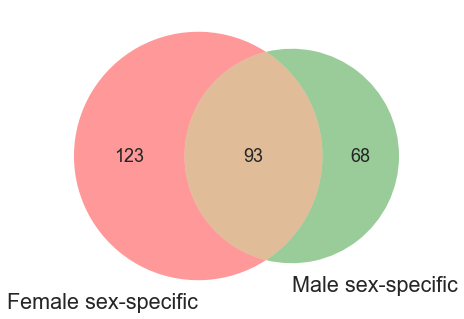

/Users/ashleymaeconard/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ashleymaeconard/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ashleymaeconard/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

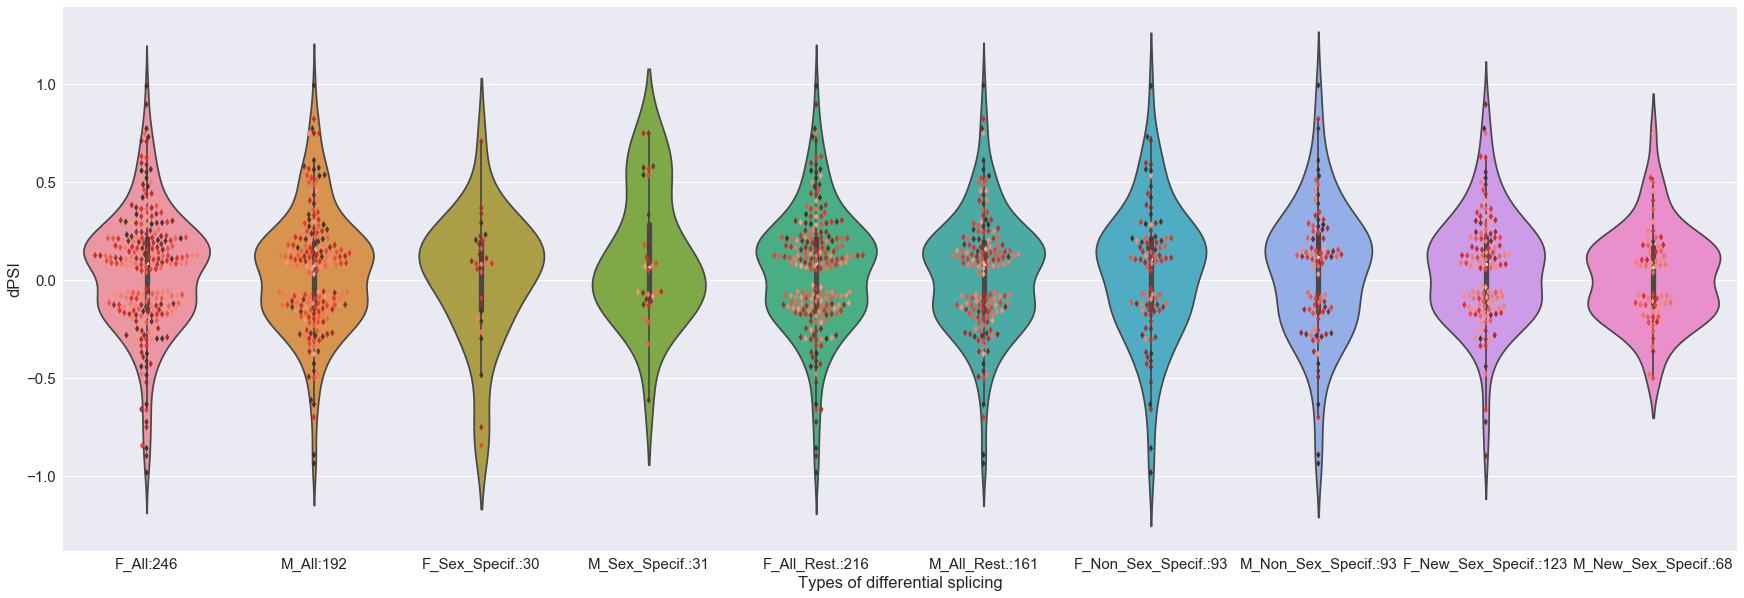

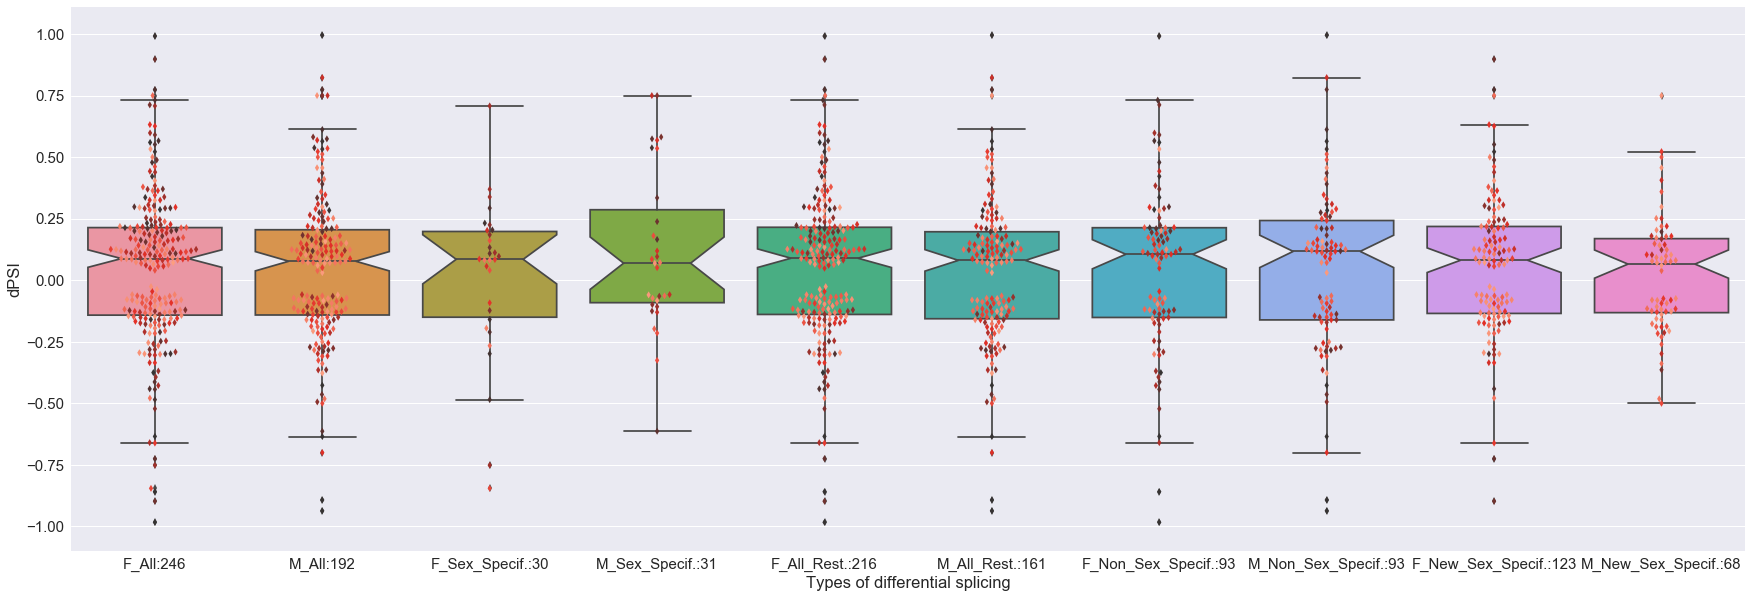

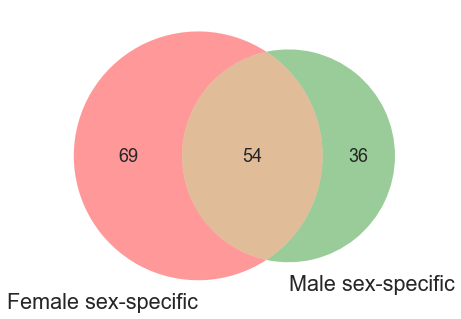

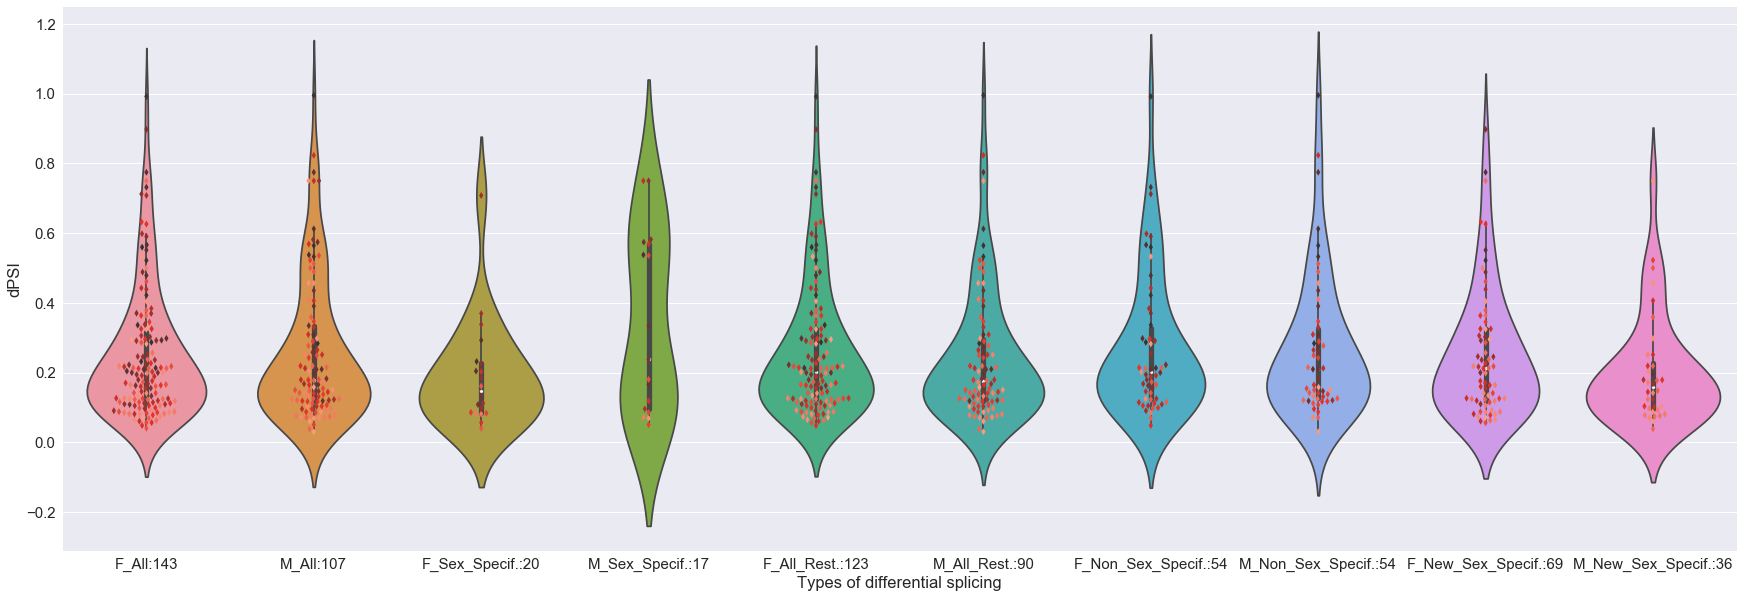

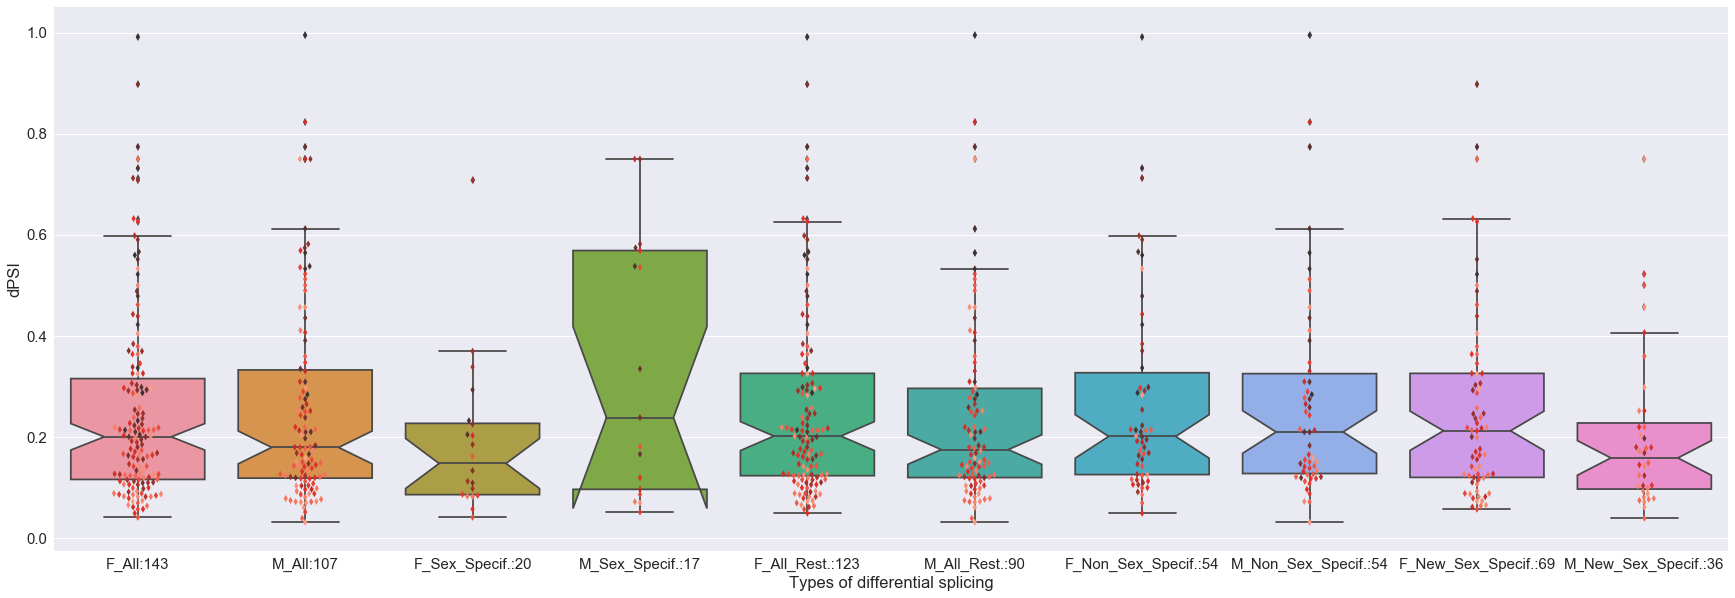

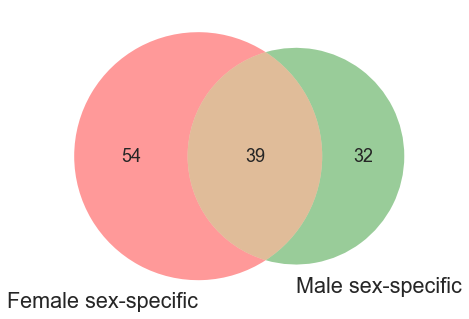

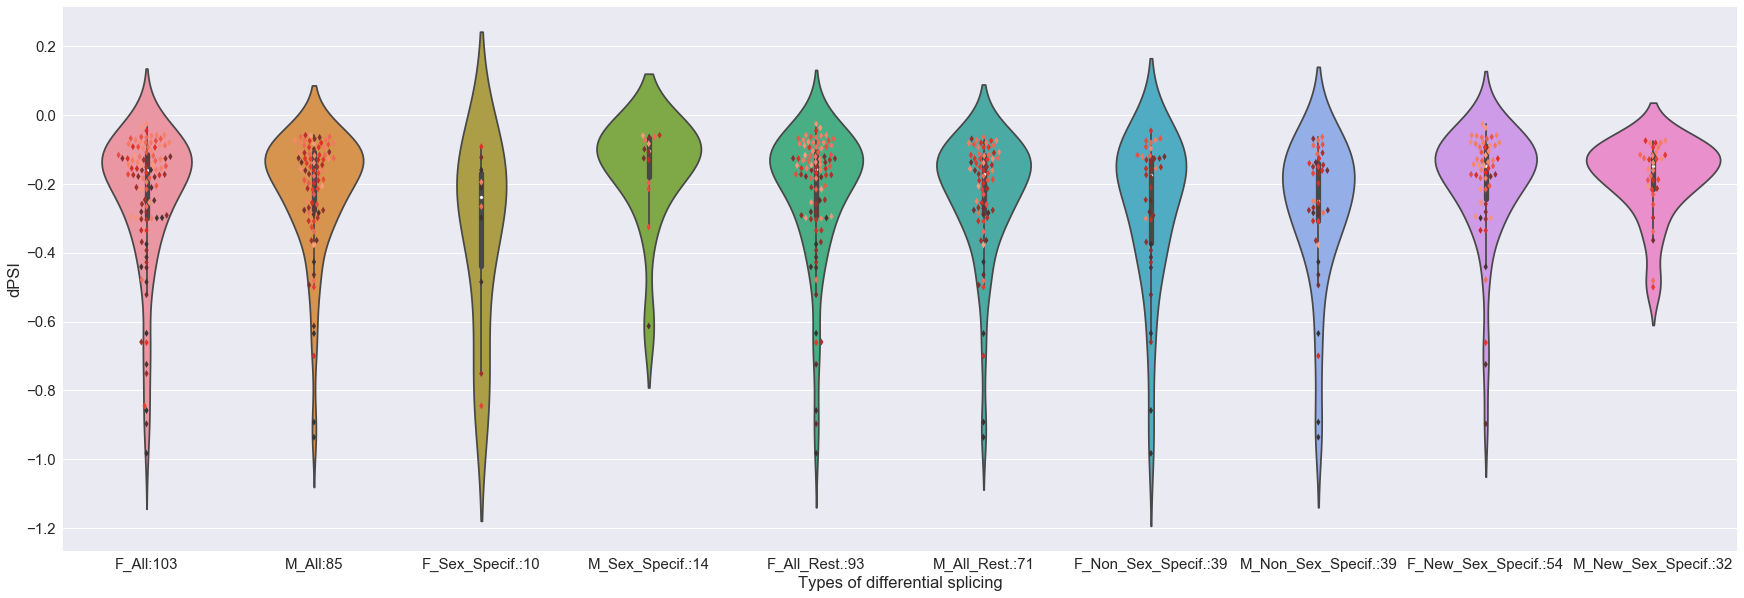

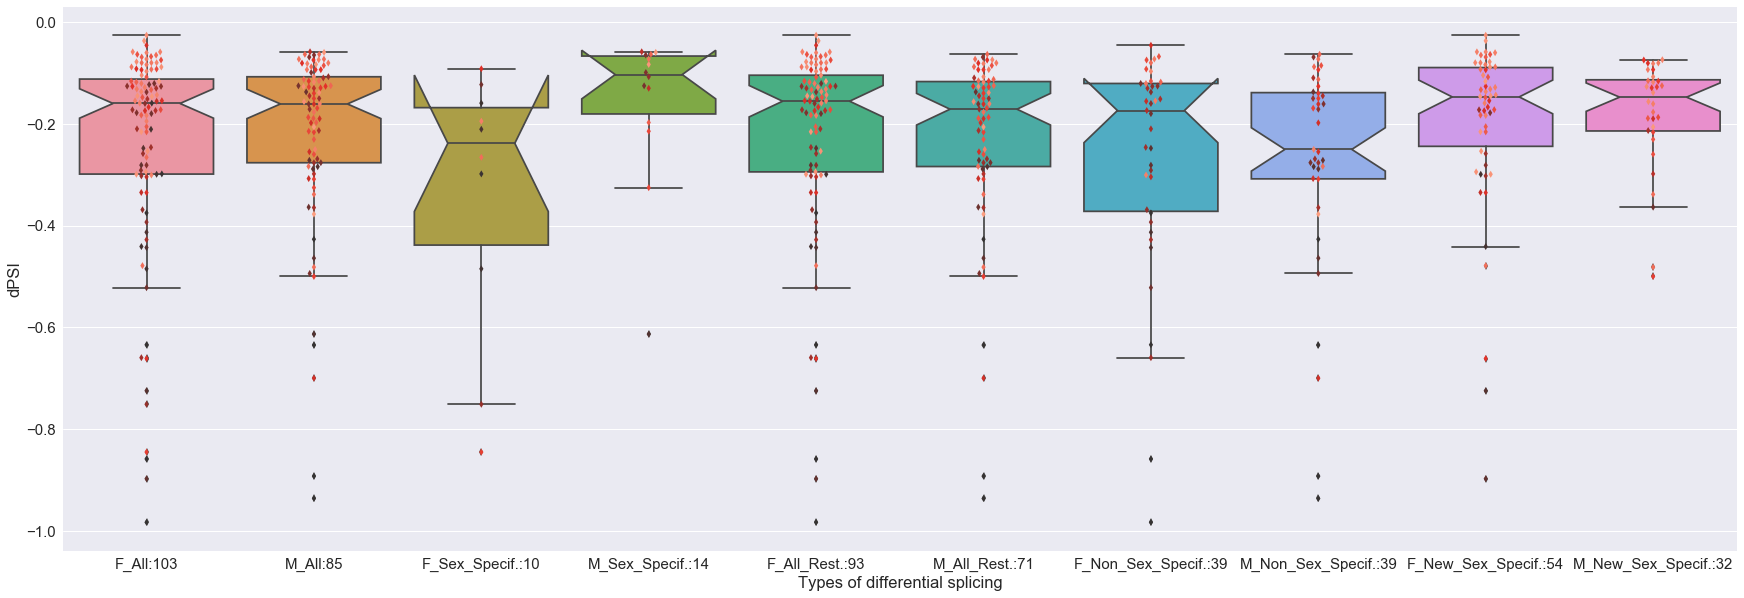

In [83]:
import dill
female_input = INPUTFILE_PSI_CAT2
male_input = INPUTFILE_PSI_CAT1

df_f = pd.read_csv(female_input, sep="\t")
PSI1 = df_f.columns[0]
pval1 = df_f.columns[1]
df_fp = df_f[df_f[PSI1] > 0.0]
df_fn = df_f[df_f[PSI1] < 0.0]
df_fz = df_f[df_f[PSI1] == 0.0]

df_m = pd.read_csv(male_input, sep="\t")
PSI2 = df_m.columns[0]
pval2 = df_m.columns[1]
df_mp = df_m[df_m[PSI2] > 0.0]
df_mn = df_m[df_m[PSI2] < 0.0]
df_mz = df_m[df_m[PSI2] == 0.0]

df_cf_cm = pd.read_csv(INPUTFILE_PSI_CTRL, sep="\t")

# Sanity check for sizes
print(df_f.shape)
print(nans(df_f).shape)
print(df_fp.shape)
print(df_fn.shape)
print(df_fz.shape)
print(pos_neg)

# Plot violin and Venn diagrams of dPSI values given timepoint
for i in pos_neg:
    identify = "null"
    if i=="b":
        identify = "Total_dPSI"
        print("Running on both positive and negative dPSI.")
    elif i=="p": # positive set
        df_f=df_fp
        df_m=df_mp
        identify = "Pos_dPSI"
    else: # negative set
        df_f=df_fn
        df_m=df_mn
        identify = "Neg_dPSI"
    
    # All genes that are sex specific from controls
    df_cf_cm_filt = df_cf_cm[df_cf_cm[pval]<0.055]
    controls_list_ss_filt = df_cf_cm_filt.index.values.tolist() 

    # keep only the rows in the controls_input_0_2_cf_cm to get sex specific
    df_f_ss = df_f[df_f.index.isin(controls_list_ss_filt)]
    df_m_ss = df_m[df_m.index.isin(controls_list_ss_filt)]

    # All other genes that are significant but not sex specific genes
    df_f_ar = df_f[~df_f.index.isin(controls_list_ss_filt)]
    df_m_ar = df_m[~df_m.index.isin(controls_list_ss_filt)]

    # New sex specific thus are significant but not in sex specifc list (thus diff. btw males and females in comparisons)
    df_f_newss1 = df_f[~df_f.index.isin(controls_list_ss_filt)]
    df_m_newss1 = df_m[~df_m.index.isin(controls_list_ss_filt)]

    df_f_newss1_list = df_f_newss1.index.values.tolist() 
    df_m_newss1_list = df_m_newss1.index.values[:-5000].tolist() 

    # venn of overlapping ss in f and m

    # 0-2 F vs. M all
    df_f_filt = df_f[df_f[pval1]<0.055]
    df_f_filt['sex'] = 'F_All:%s'%len(df_f_filt)
    df_m_filt = df_m[df_m[pval2]<0.055]
    df_m_filt['sex'] = 'M_All:%s'%len(df_m_filt)

    df1 = df_f_filt.append(df_m_filt)

    # 0-2 Sex specific thus control F vs. M for list then filter those genes
    df_f_filt_ss = df_f_ss[df_f_ss[pval1]<0.055]
    df_f_filt_ss['sex'] = 'F_Sex_Specif.:%s'%len(df_f_filt_ss)
    df_m_filt_ss = df_m_ss[df_m_ss[pval2]<0.055]
    df_m_filt_ss['sex'] = 'M_Sex_Specif.:%s'%len(df_m_filt_ss)

    df2 = df1.append(df_f_filt_ss)
    df3 = df2.append(df_m_filt_ss)

    # 0-2 All rest 
    df_f_filt_ar = df_f_ar[df_f_ar[pval1]<0.055]
    df_f_filt_ar['sex'] = 'F_All_Rest.:%s'%len(df_f_filt_ar)
    df_m_filt_ar = df_m_ar[df_m_ar[pval2]<0.055]
    df_m_filt_ar['sex'] = 'M_All_Rest.:%s'%len(df_m_filt_ar)

    df_f_filt_ar_list = df_f_filt_ar.index.values.tolist() 
    df_m_filt_ar_list = df_m_filt_ar.index.values.tolist() 

    df4 = df3.append(df_f_filt_ar)
    df5 = df4.append(df_m_filt_ar) 

    # Venn diagram between them
    venn2([set(df_f_filt_ar_list), set(df_m_filt_ar_list)],
        set_labels = (CAT1, CAT2)) # 'Female sex-specific', 'Male sex-specific'
    plt.savefig(OUTDIR+"/"+TIME+"_"+identify+"_"+"_venn_PSI.pdf")
    plt.show()

    # 0-2 NOT sex specific thus ~control F vs. M list then filter those genes
    df_filt_nss_list = intersection(df_f_filt_ar_list, df_m_filt_ar_list)
    df_f_filt_nss = df_f_filt_ar[df_f_filt_ar.index.isin(df_filt_nss_list)]
    df_f_filt_nss['sex'] = 'F_Non_Sex_Specif.:%s'%len(df_f_filt_nss)
    df_m_filt_nss = df_m_filt_ar[df_m_filt_ar.index.isin(df_filt_nss_list)]
    df_m_filt_nss['sex'] = 'M_Non_Sex_Specif.:%s'%len(df_m_filt_nss)

    df6 = df5.append(df_f_filt_nss)
    df7 = df6.append(df_m_filt_nss)

    # 0-2 New sex specific thus ~control F vs. M list then filter those gene
    df_f_filt_newss_list = list(set(df_f_filt_ar_list) - set(df_m_filt_ar_list))
    df_f_filt_newss = df_f_filt_ar[df_f_filt_ar.index.isin(df_f_filt_newss_list)]
    df_f_filt_newss['sex'] = 'F_New_Sex_Specif.:%s'%len(df_f_filt_newss)

    df_m_filt_newss_list = list(set(df_m_filt_ar_list) - set(df_f_filt_ar_list))
    df_m_filt_newss = df_m_filt_ar[df_m_filt_ar.index.isin(df_m_filt_newss_list)]
    df_m_filt_newss['sex'] = 'M_New_Sex_Specif.:%s'%len(df_m_filt_newss)

    df8 = df7.append(df_f_filt_newss)
    df9_psi = df8.append(df_m_filt_newss)
    
    dill.dump(df9_psi, file = open("myObject.pickle", "wb"))

    #### Plots 
    sns.set(style="whitegrid")
    # Make boxplot for one group only
    sns.set(font_scale = 1.2)
    f = plt.figure(figsize=(30,10))
    ax = f.add_subplot(111)
    #pal = sns.palplot(sns.light_palette("navy", reverse=True))

    sns.set_palette("Paired")
    sns.violinplot( x="sex", y=PSI1, data=df9_psi)

    # sequential_colors = sns.color_palette("RdPu", 100)
    # sns.palplot(sequential_colors)

    sns.swarmplot( x="sex", y=PSI1, color='red', marker="d", hue=pval1, data=df9_psi, palette="Reds_d")
    ax.get_legend().set_visible(False)
    ax.set(xlabel='Types of differential splicing', ylabel='dPSI')
    plt.savefig(OUTDIR+"/"+TIME+"_"+identify+"_"+"_violin_PSI.pdf")
    plt.show()
    
    ########

    sns.set(style="whitegrid")
    # Make boxplot for one group only
    sns.set(font_scale = 1.2)
    f = plt.figure(figsize=(30,10))
    ax = f.add_subplot(111)
    #pal = sns.palplot(sns.light_palette("navy", reverse=True))

    sns.set_palette("Paired")
    sns.boxplot( x="sex", y=PSI2, data=df9_psi, notch="TRUE")

    sns.swarmplot( x="sex", y=PSI2, color='red', marker="d", hue=pval2, data=df9_psi, palette="Reds_d")
    ax.get_legend().set_visible(False)
    ax.set(xlabel='Types of differential splicing', ylabel='dPSI')
    plt.savefig(OUTDIR+"/"+TIME+"_"+identify+"_"+"_boxplot_PSI.pdf")
    plt.show()

    # MOD: ADD A CSV THAT PRINTS OUT ALL SPLICING EVENTS AND CATEGORIES!
    total = ((((df_f_filt.append(df_m_filt)).append(df_f_filt_ss)).append(df_m_filt_ss)).append(df_f_filt_ar)).append(df_m_filt_ar)
    total2 = (((total.append(df_f_filt_nss)).append(df_m_filt_nss)).append(df_f_filt_newss)).append(df_m_filt_newss)
    total2.to_csv(OUTDIR + "/" + "splicing_cats" + identify + ".csv")

    #### K-S Tests
    with open(OUTDIR+"/"+TIME+"_"+identify+"_"+"_ksTest_PSI.txt", 'w') as f:
        # All
        psi_f_all = np.asarray(df_f_filt[PSI1])
        psi_m_all = np.asarray(df_m_filt[PSI2])
        # print >> f, "All K-S Test: ", stats.ks_2samp(psi_f_all, psi_m_all)
        f.write("All K-S Test: \n")
        print(stats.ks_2samp(psi_f_all, psi_m_all), f)
        print("\n")

        # Sex specific
        psi_f_ss = np.asarray(df_f_filt_ss[PSI1])
        psi_m_ss = np.asarray(df_m_filt_ss[PSI2])
        # print >> f, "Sex specific K-S Test: ", stats.ks_2samp(psi_f_ss, psi_m_ss)
        f.write("\nSex specific K-S Test: \n")
        print(stats.ks_2samp(psi_f_ss, psi_m_ss), f)
        print("\n")
                
        # All rest
        psi_f_ar = np.asarray(df_f_filt_ar[PSI1])
        psi_m_ar = np.asarray(df_m_filt_ar[PSI2])
        # print >> f, "All rest K-S Test: ", stats.ks_2samp(psi_f_ar, psi_m_ar)
        f.write("\nAll rest K-S Test: \n")
        print(stats.ks_2samp(psi_f_ar, psi_m_ar), f)
        print("\n")

        # Non-sex specif.
        psi_f_nss = np.asarray(df_f_filt_nss[PSI1])
        psi_m_nss = np.asarray(df_m_filt_nss[PSI2])
        #print >> f, "Non-sex specific K-S Test: ", stats.ks_2samp(psi_f_nss, psi_m_nss)
        f.write("\nNon-sex specific K-S Test: \n")
        
        if (i != "p"):
            print(stats.ks_2samp(psi_f_nss, psi_m_nss), f)
        print("\n")

        # New sex specif.
        psi_f_newss = np.asarray(df_f_filt_newss[PSI1])
        psi_m_newss = np.asarray(df_m_filt_newss[PSI2])
        #print >> f, "New sex specific K-S Test: ", stats.ks_2samp(psi_f_newss, psi_m_newss)
        f.write("\nNew sex specific K-S Test: \n")
        print(stats.ks_2samp(psi_f_newss, psi_m_newss), f)



# DTU Venn diagrams, violin plots, and notch plots

/Users/ashleymaeconard/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ashleymaeconard/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ashleymaeconard/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

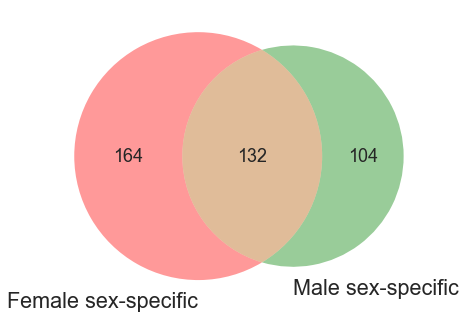

/Users/ashleymaeconard/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ashleymaeconard/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ashleymaeconard/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

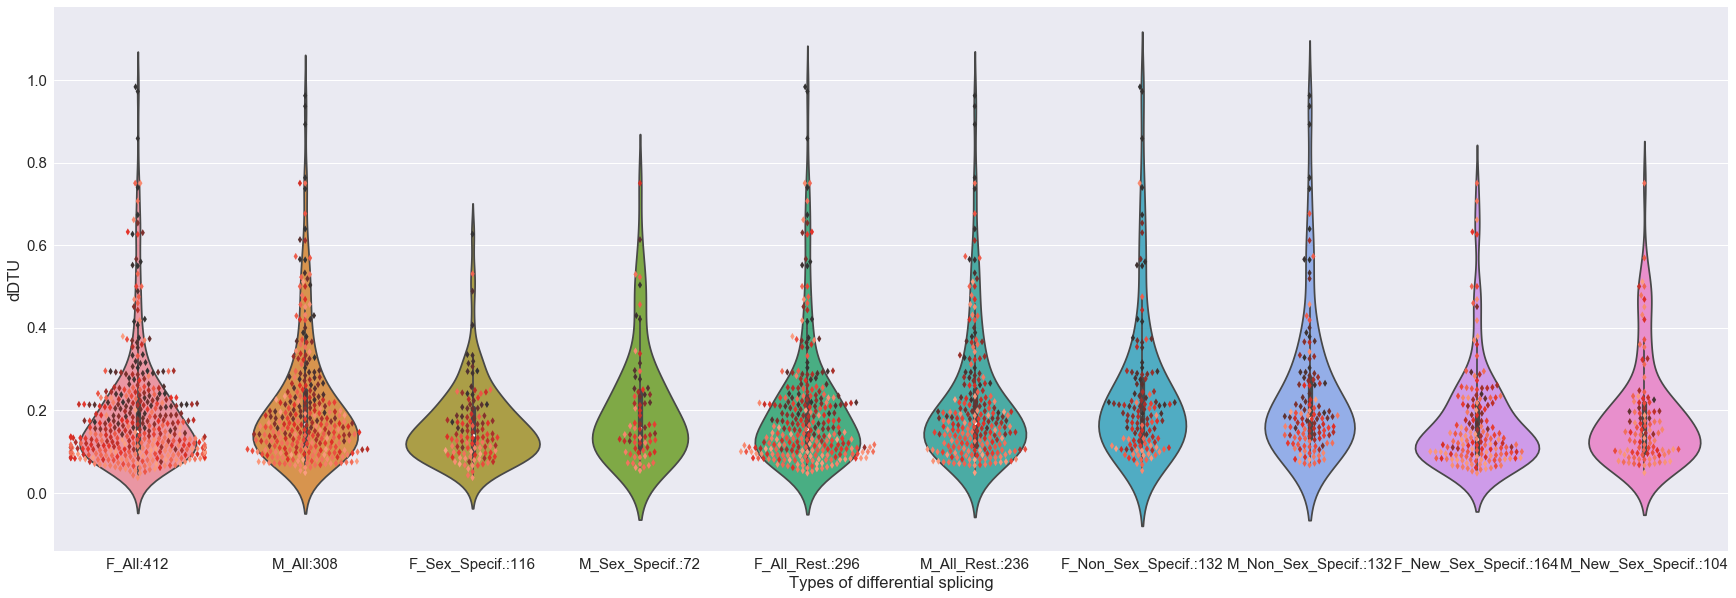

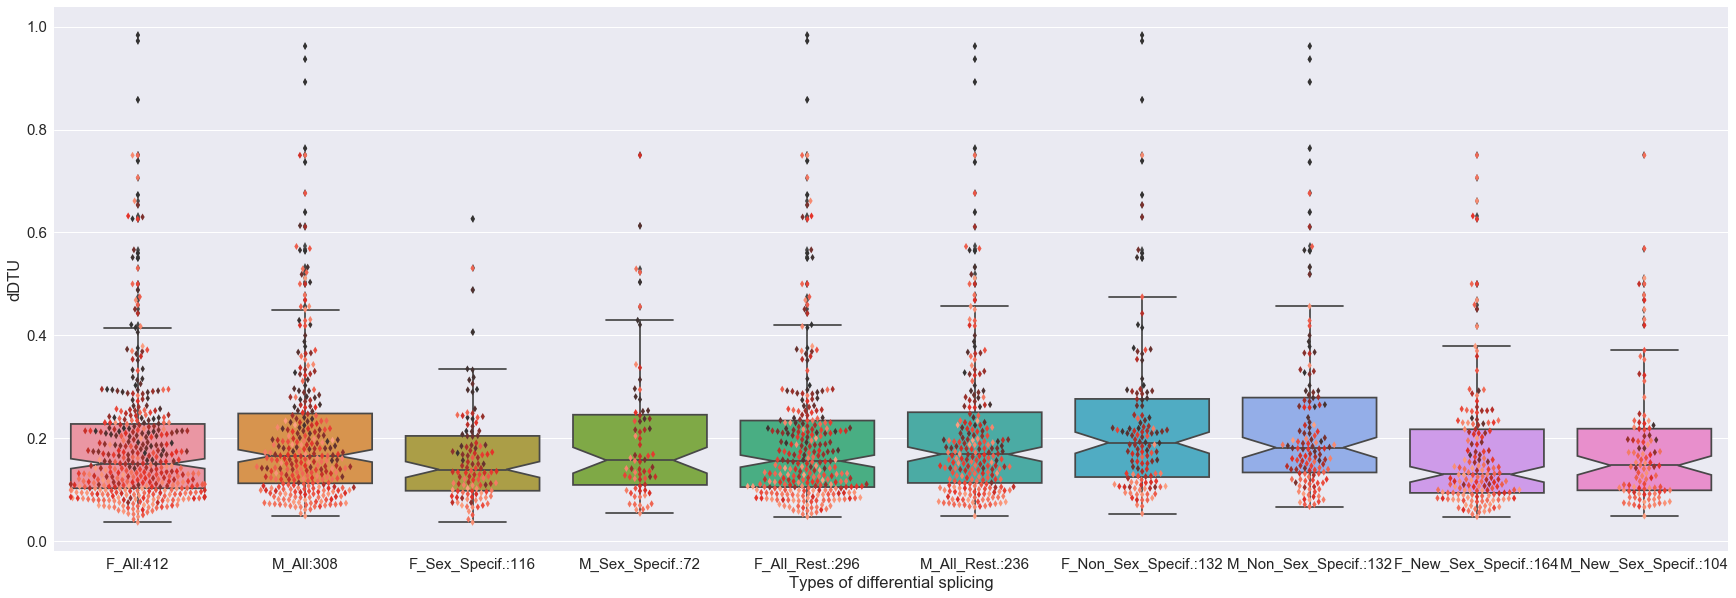

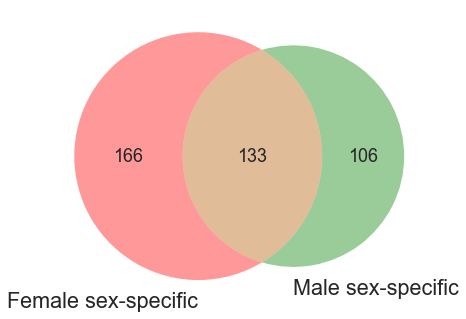

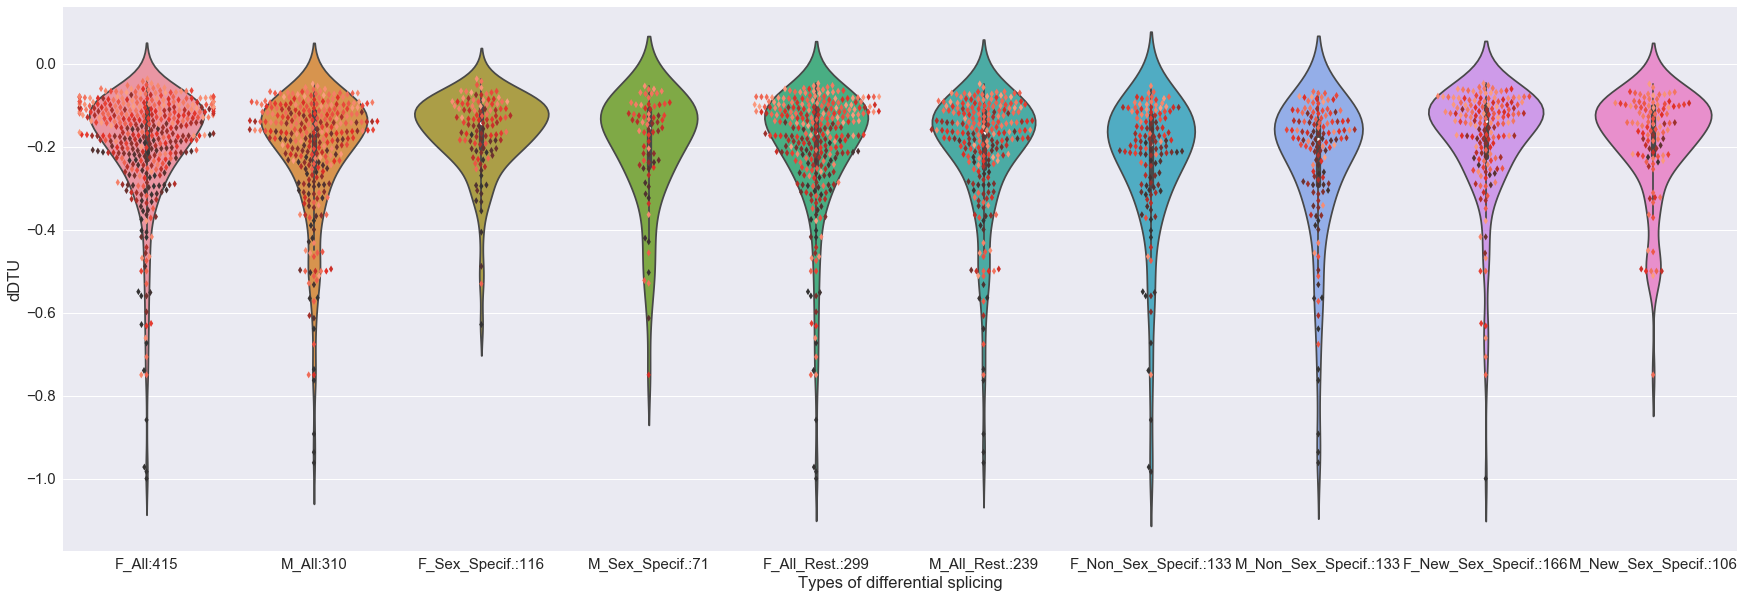

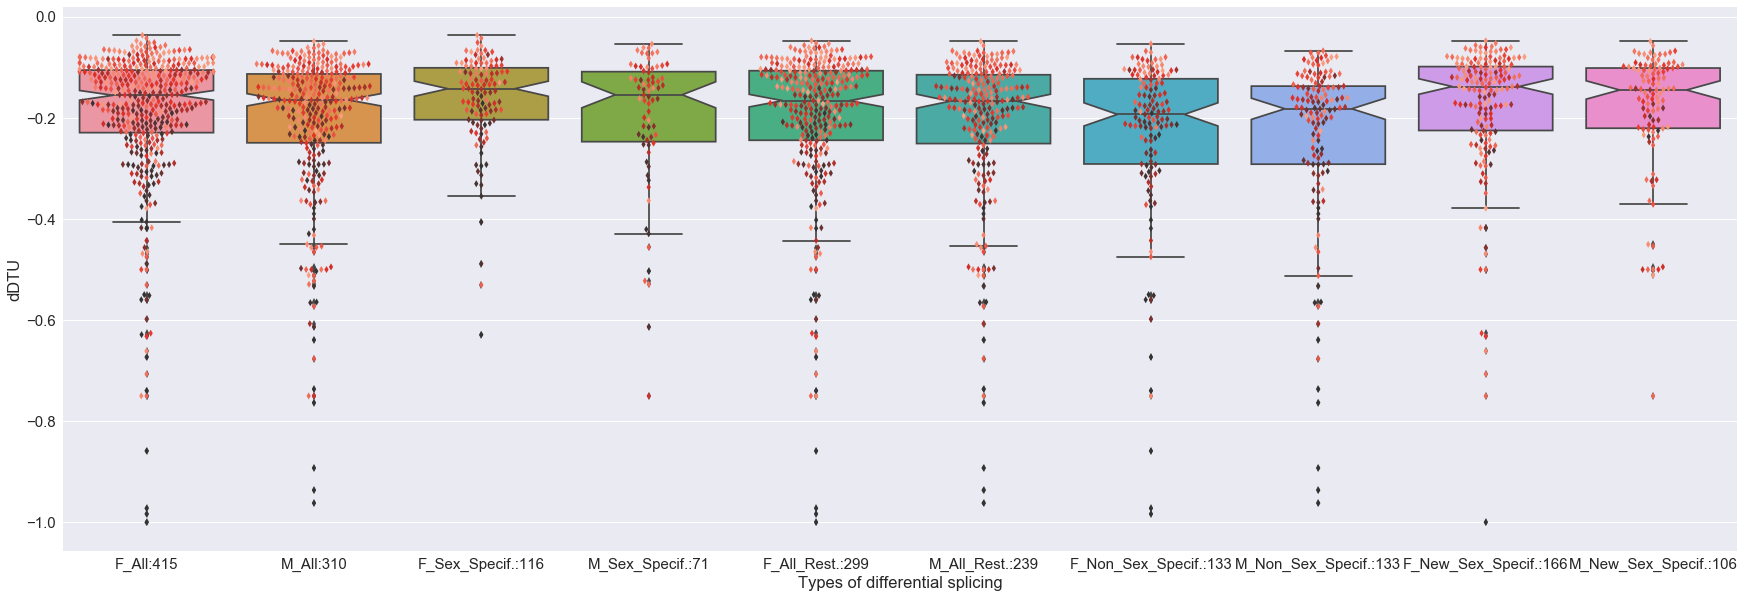

In [72]:
# Data import and thresholding
female_input_0_2_f = INPUTFILE_DTU_CAT1
male_input_0_2_m = INPUTFILE_DTU_CAT2

df_0_2f = pd.read_csv(female_input_0_2_f, sep="\t")
df_0_2fp = df_0_2f[df_0_2f[DTU] > 0.0]
df_0_2fn = df_0_2f[df_0_2f[DTU] < 0.0]
df_0_2fz = df_0_2f[df_0_2f[DTU] == 0.0]

df_0_2m = pd.read_csv(male_input_0_2_m, sep="\t")
df_0_2mp = df_0_2m[df_0_2m[DTU] > 0.0]
df_0_2mn = df_0_2m[df_0_2m[DTU] < 0.0]
df_0_2mz = df_0_2m[df_0_2m[DTU] == 0.0]

# Sanity check for sizes
print(df_0_2f.shape)
print(nans(df_0_2f).shape)
print(df_0_2fp.shape)
print(df_0_2fn.shape)
print(df_0_2fz.shape)

for i in pos_neg:
    if i=="b":
        print("Running on both positive and negative dDTU.")  
    elif i=="p": # positive set
        df_0_2f=df_0_2fp
        df_0_2m=df_0_2mp
    else: # negative set
        df_0_2f=df_0_2fn
        df_0_2m=df_0_2mn
        
    # All genes that are sex specific from controls
    df_0_2_cf_cm_filt = df_0_2_cf_cm_DTU[df_0_2_cf_cm_DTU[pvaldtu]<=0.05]
    controls_list_ss_filt = df_0_2_cf_cm_filt.index.values.tolist() 

    # keep only the rows in the controls_input_0_2_cf_cm to get sex specific
    df_0_2_f_ss = df_0_2f[df_0_2f.index.isin(controls_list_ss_filt)]
    df_0_2_m_ss = df_0_2m[df_0_2m.index.isin(controls_list_ss_filt)]

    # All other genes that are significant but not sex specific genes
    df_0_2_f_ar = df_0_2f[~df_0_2f.index.isin(controls_list_ss_filt)]
    df_0_2_m_ar = df_0_2m[~df_0_2m.index.isin(controls_list_ss_filt)]

    # New sex specific thus are significant but not in sex specifc list (thus diff. btw males and females in comparisons)
    df_0_2f_newss1 = df_0_2f[~df_0_2f.index.isin(controls_list_ss_filt)]
    df_0_2m_newss1 = df_0_2m[~df_0_2m.index.isin(controls_list_ss_filt)]

    df_0_2f_newss1_list = df_0_2f_newss1.index.values.tolist() 
    df_0_2m_newss1_list = df_0_2m_newss1.index.values[:-5000].tolist() 

    # venn of overlapping ss in f and m

    # 0-2 F vs. M all
    df_0_2f_filt = df_0_2f[df_0_2f[pvaldtu]<=0.05]
    df_0_2f_filt['sex'] = 'F_All:%s'%len(df_0_2f_filt)
    df_0_2m_filt = df_0_2m[df_0_2m[pvaldtu]<=0.05]
    df_0_2m_filt['sex'] = 'M_All:%s'%len(df_0_2m_filt)

    df1 = df_0_2f_filt.append(df_0_2m_filt)

    # 0-2 Sex specific thus control F vs. M for list then filter those genes
    df_0_2f_filt_ss = df_0_2_f_ss[df_0_2_f_ss[pvaldtu]<=0.05]
    df_0_2f_filt_ss['sex'] = 'F_Sex_Specif.:%s'%len(df_0_2f_filt_ss)
    df_0_2m_filt_ss = df_0_2_m_ss[df_0_2_m_ss[pvaldtu]<=0.05]
    df_0_2m_filt_ss['sex'] = 'M_Sex_Specif.:%s'%len(df_0_2m_filt_ss)

    df2 = df1.append(df_0_2f_filt_ss)
    df3 = df2.append(df_0_2m_filt_ss)

    # 0-2 All rest 
    df_0_2f_filt_ar = df_0_2_f_ar[df_0_2_f_ar[pvaldtu]<=0.05]
    df_0_2f_filt_ar['sex'] = 'F_All_Rest.:%s'%len(df_0_2f_filt_ar)
    df_0_2m_filt_ar = df_0_2_m_ar[df_0_2_m_ar[pvaldtu]<=0.05]
    df_0_2m_filt_ar['sex'] = 'M_All_Rest.:%s'%len(df_0_2m_filt_ar)

    df_0_2f_filt_ar_list = df_0_2f_filt_ar.index.values.tolist() 
    df_0_2m_filt_ar_list = df_0_2m_filt_ar.index.values.tolist() 

    df4 = df3.append(df_0_2f_filt_ar)
    df5 = df4.append(df_0_2m_filt_ar) 

    # Venn diagram between them
    venn2([set(df_0_2f_filt_ar_list), set(df_0_2m_filt_ar_list)],
        set_labels = (CAT1, CAT2)) # 'Female sex-specific', 'Male sex-specific'
    plt.savefig(OUTDIR+"/"+TIME+"_"+i+"_"+"_venn_DTU.pdf")
    plt.show()

    # 0-2 NOT sex specific thus ~control F vs. M list then filter those genes
    df_0_2filt_nss_list = intersection(df_0_2f_filt_ar_list, df_0_2m_filt_ar_list)
    df_0_2f_filt_nss = df_0_2f_filt_ar[df_0_2f_filt_ar.index.isin(df_0_2filt_nss_list)]
    df_0_2f_filt_nss['sex'] = 'F_Non_Sex_Specif.:%s'%len(df_0_2f_filt_nss)
    df_0_2m_filt_nss = df_0_2m_filt_ar[df_0_2m_filt_ar.index.isin(df_0_2filt_nss_list)]
    df_0_2m_filt_nss['sex'] = 'M_Non_Sex_Specif.:%s'%len(df_0_2m_filt_nss)

    df6 = df5.append(df_0_2f_filt_nss)
    df7 = df6.append(df_0_2m_filt_nss)

    # 0-2 New sex specific thus ~control F vs. M list then filter those gene
    df_0_2f_filt_newss_list = list(set(df_0_2f_filt_ar_list) - set(df_0_2m_filt_ar_list))
    df_0_2f_filt_newss = df_0_2f_filt_ar[df_0_2f_filt_ar.index.isin(df_0_2f_filt_newss_list)]
    df_0_2f_filt_newss['sex'] = 'F_New_Sex_Specif.:%s'%len(df_0_2f_filt_newss)

    df_0_2m_filt_newss_list = list(set(df_0_2m_filt_ar_list) - set(df_0_2f_filt_ar_list))
    df_0_2m_filt_newss = df_0_2m_filt_ar[df_0_2m_filt_ar.index.isin(df_0_2m_filt_newss_list)]
    df_0_2m_filt_newss['sex'] = 'M_New_Sex_Specif.:%s'%len(df_0_2m_filt_newss)

    df8 = df7.append(df_0_2f_filt_newss)
    df9_0_2_dtu = df8.append(df_0_2m_filt_newss)

    #### Plots 
    sns.set(style="whitegrid")
    # Make boxplot for one group only
    sns.set(font_scale = 1.5)
    f = plt.figure(figsize=(30,10))
    ax = f.add_subplot(111)
    #pal = sns.palplot(sns.light_palette("navy", reverse=True))

    sns.set_palette("Paired")
    sns.violinplot( x="sex", y=DTU, data=df9_0_2_dtu)

    # sequential_colors = sns.color_palette("RdPu", 100)
    # sns.palplot(sequential_colors)

    sns.swarmplot( x="sex", y=DTU, color='red', marker="d", hue=pvaldtu, data=df9_0_2_dtu, palette="Reds_d")
    ax.get_legend().set_visible(False)
    ax.set(xlabel='Types of differential splicing', ylabel='dDTU')
    plt.savefig(OUTDIR+"/"+TIME+"_"+i+"_"+"_violin_DTU.pdf")
    sns.plt.show()

    sns.set(style="whitegrid")
    # Make boxplot for one group only
    sns.set(font_scale = 1.5)
    f = plt.figure(figsize=(30,10))
    ax = f.add_subplot(111)
    #pal = sns.palplot(sns.light_palette("navy", reverse=True))

    sns.set_palette("Paired")
    sns.boxplot( x="sex", y=DTU, data=df9_0_2_dtu, notch="TRUE")

    sns.swarmplot( x="sex", y=DTU, color='red', marker="d", hue=pvaldtu, data=df9_0_2_dtu, palette="Reds_d")
    ax.get_legend().set_visible(False)
    ax.set(xlabel='Types of differential splicing', ylabel='dDTU')
    plt.savefig(OUTDIR+"/"+TIME+"_"+i+"_"+"_boxplot_DTU.pdf")
    sns.plt.show()

    #### K-S Tests
    with open(OUTDIR+"/"+TIME+"_"+i+"_"+"_ksTest_DTU.txt", 'w') as f:
        # All
        DTU_f_all = np.asarray(df_0_2f_filt[DTU])
        DTU_m_all = np.asarray(df_0_2m_filt[DTU])
        print >> f, "All K-S Test: ", stats.ks_2samp(DTU_f_all, DTU_m_all)

        # Sex specific
        DTU_f_ss = np.asarray(df_0_2f_filt_ss[DTU])
        DTU_m_ss = np.asarray(df_0_2m_filt_ss[DTU])
        print >> f, "Sex specific K-S Test: ", stats.ks_2samp(DTU_f_ss, DTU_m_ss)

        # All rest
        DTU_f_ar = np.asarray(df_0_2f_filt_ar[DTU])
        DTU_m_ar = np.asarray(df_0_2m_filt_ar[DTU])
        print >> f, "All rest K-S Test: ", stats.ks_2samp(DTU_f_ar, DTU_m_ar)

        # Non-sex specif.
        DTU_f_nss = np.asarray(df_0_2f_filt_nss[DTU])
        DTU_m_nss = np.asarray(df_0_2m_filt_nss[DTU])
        print >> f, "Non-sex specific K-S Test: ", stats.ks_2samp(DTU_f_nss, DTU_m_nss)

        # New sex specif.
        DTU_f_newss = np.asarray(df_0_2f_filt_newss[DTU])
        DTU_m_newss = np.asarray(df_0_2m_filt_newss[DTU])
        print >> f, "New sex specific K-S Test: ", stats.ks_2samp(DTU_f_newss, DTU_m_newss)

# 5. Formatting genes.gtf file for final outputs

In [18]:
# IMPORTING GENES.GTF FILE 
df_genes_gtf = pd.read_csv(GENES_GTF, sep="\t",usecols=[0,2,3,4,8], names=['chrom','type_prot', 'start_chrom', 
                                                       'end_chrom', 'allInfo'], engine='python')
df_genes_gtf['allInfo'] = df_genes_gtf['allInfo'].map(lambda x: str(x)[:-1])
df_genes_gtf.columns.str.replace(' ', '')
list_cols =["gene_name", "gene_biotype", "gene_id", "transcript_name", "transcript_id","transcript_biotype", "tss_id"]

print("Example of 'allInfo' column in df_genes_gtf['allInfo'] that I will parse into these columns: \n\n", list_cols,"\n\n", df_genes_gtf["allInfo"][0])

# Iterate through all gene information (from allInfo in df_genes_gtf of genes.gtf) to keep
for search_word in list_cols:
    df_genes_gtf[search_word] = df_genes_gtf.apply(create_cols,axis=1)
    df_genes_gtf[search_word] = df_genes_gtf[search_word].str.replace(';','')
    df_genes_gtf[search_word] = df_genes_gtf[search_word].str.replace('"', '')

#df_genes_gtf = df_genes_gtf.drop(columns=['allInfo'])
df_genes_gtf = df_genes_gtf.drop_duplicates(subset="gene_id")
df_genes_gtf = df_genes_gtf.reset_index()
print("Number of unique genes based on FlyBase ID from ", GENES_GTF,": ", len(df_genes_gtf))

df_genes_gtf["exon_id"]=df_genes_gtf.apply(add_exon_id, axis=1)
df_genes_gtf["exon_number"]=df_genes_gtf.apply(add_exon_number, axis=1)
df_genes_gtf = df_genes_gtf.reset_index()
df_genes_gtf = df_genes_gtf.drop(['allInfo','index'], axis=1)

Example of 'allInfo' column in df_genes_gtf['allInfo'] that I will parse into these columns: 

 ['gene_name', 'gene_biotype', 'gene_id', 'transcript_name', 'transcript_id', 'transcript_biotype', 'tss_id'] 

 exon_id "FBtr0114187-E1"; exon_number "1"; exon_version "1"; gene_biotype "rRNA"; gene_id "FBgn0085737"; gene_name "CR40502"; gene_source "FlyBase"; gene_version "1"; transcript_biotype "rRNA"; transcript_id "FBtr0114187"; transcript_name "CR40502-RA"; transcript_source "FlyBase"; transcript_version "1"; tss_id "TSS6218"


# 6. Save outputs

In [1]:
# Add gene_name to output files for PSI and DTU for each timepoint
# df9_0_2_psi
# Add gene_name to output files for PSI and DTU for each timepoint
df9_psi['gene_id']= df9_psi.apply(parse_index,axis=1)
df9_psi['trans_event'] = df9_psi.index
df9_psi.index = df9_psi['New_ID']
df9_psi = df9_psi.drop(['New_ID'], axis=1)
new_df9_psi = pd.merge(df9_psi, df_genes_gtf[['gene_id','gene_name', 'gene_biotype']], on='gene_id')

cols = list(new_df9_psi)
cols.insert(0, cols.pop(cols.index('gene_name')))
new_df9_psi = new_df9_psi.ix[:, cols]
new_df9_psi.to_csv(OUTDIR+"/"+OUTPUT_NAME+"_psi.tsv", sep="\t", index=False)

# df9_0_2_dtu
df9_0_2_dtu['gene_id']= df9_0_2_dtu.apply(parse_index,axis=1)
df9_0_2_dtu['trans_event'] = df9_0_2_dtu.index
df9_0_2_dtu.index = df9_0_2_dtu['New_ID']
new_df9_0_2_dtu = pd.merge(df9_0_2_dtu, df_genes_gtf[['gene_id','gene_name', 'gene_biotype']], on='gene_id')

cols = list(new_df9_0_2_dtu)
cols.insert(0, cols.pop(cols.index('gene_name')))
new_df9_0_2_dtu = new_df9_0_2_dtu.ix[:, cols]
new_df9_0_2_dtu.to_csv(OUTDIR+"/"+OUTPUT_NAME+"_dtu.tsv", sep="\t", index=False)